# Imports

In [60]:
import warnings
warnings.filterwarnings("ignore")

import os

import datetime

from typing import Union

import numpy as np
import pandas as pd

import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion, FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Binarizer, OneHotEncoder, OrdinalEncoder, KBinsDiscretizer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, VotingClassifier

import catboost
import xgboost

In [2]:
import sklearn
from sklearn import set_config

In [3]:
print(f"scikit-learn version is {sklearn.__version__}")

scikit-learn version is 1.4.1.post1


In [4]:
if sklearn.__version__ not in ["1.2.0", "1.2.2", "1.4.1.post1"]:
    os.system("pip install scikit-learn==1.2.0")

# Global Configuration

In [5]:
set_config(transform_output="pandas")

In [6]:
CWD = os.getcwd()
KAGGLE = "kaggle" in CWD

In [7]:
print(CWD)

/Users/nicolaepopescul/Desktop/streams/20240328_sklearn_modelo_benchmark_ml


In [8]:
if not KAGGLE:
    PATH_INPUT = os.path.join(CWD, "input")
    PATH_INPUT_TRAIN = os.path.join(PATH_INPUT, "train.csv")
    PATH_INPUT_TEST = os.path.join(PATH_INPUT, "test.csv")
    
    print(os.listdir(PATH_INPUT))
    
else:
    PATH_INPUT_TRAIN = "/kaggle/input/spaceship-titanic/train.csv"
    PATH_INPUT_TEST = "/kaggle/input/spaceship-titanic/test.csv"

['test.csv', 'spaceship-titanic.zip', 'train.csv', 'sample_submission.csv']


In [9]:
sorted(os.listdir(CWD))

['.DS_Store',
 '.git',
 '.gitignore',
 '.ipynb_checkpoints',
 'EDA.ipynb',
 'MODEL.ipynb',
 'catboost_info',
 'input',
 'notebooks',
 'outputs',
 'requirements.txt',
 'src',
 'venvs',
 'videos']

# Helper functions

In [10]:
def load_data():
    
    X_train = pd.read_csv(PATH_INPUT_TRAIN).set_index("PassengerId")
    X_test = pd.read_csv(PATH_INPUT_TEST).set_index("PassengerId")
    
    return X_train, X_test

# Dataset loading & EDA

In [11]:
X, _ = load_data()

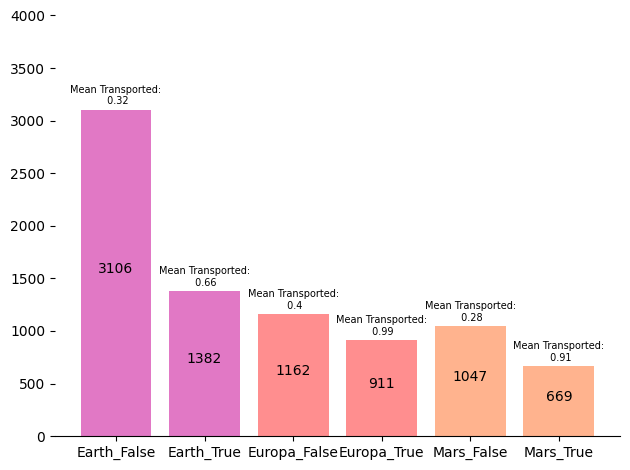

In [71]:
colors = {
    "Earth" : "#E178C5",
    "Europa" : "#FF8E8F",
    "Mars" : "#FFB38E"
}

X_ = (
    X[["HomePlanet", "CryoSleep", "Transported"]]
    .groupby(["HomePlanet", "CryoSleep"])
    .agg(
        nr = ("Transported", len),
        mean_target = ("Transported", np.mean)
    )
    .reset_index()
)

fig = plt.figure()
ax = fig.add_subplot()

ax.set_ylim(0, 4000)

for planet, sleep in zip(X_["HomePlanet"].values, X_["CryoSleep"].values):
    
    cat = str(planet) + "_" + str(sleep)
    
    nr = X_[(X_["HomePlanet"] == planet) & (X_["CryoSleep"] == sleep)]["nr"].iloc[0]
    mean_target = X_[(X_["HomePlanet"] == planet) & (X_["CryoSleep"] == sleep)]["mean_target"].iloc[0]
    
    ax.bar(
        x = cat,
        height = nr,
        color = colors[planet]
    )

    ax.text(
        x = cat,
        y = nr//2,
        s = nr,
        horizontalalignment = "center"
    )
        
    ax.text(
        x = cat,
        y = nr + 50,
        s = f"Mean Transported:\n {str(round(mean_target, 2))}",
        horizontalalignment = "center",
        size = 7
    )
    
ax.spines["top"].set_color("none")
ax.spines["left"].set_color("none")
ax.spines["right"].set_color("none")

plt.tight_layout();

In [16]:
cols = [
    'RoomService',
    'FoodCourt',
    'ShoppingMall',
    'Spa',
    'VRDeck',
    'Transported'
]

In [24]:
(
    X[cols]
    .assign(TotalSpent = lambda df: df.iloc[:, :5].sum(axis = 1))
    .corr()
    .style.background_gradient()
)

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,TotalSpent
RoomService,1.000000,-0.015889,0.054480,0.010080,-0.019581,-0.244611,0.237998
FoodCourt,-0.015889,1.000000,-0.014228,0.221891,0.227995,0.046566,0.745105
ShoppingMall,0.054480,-0.014228,1.000000,0.013879,-0.007322,0.010141,0.222310
Spa,0.010080,0.221891,0.013879,1.000000,0.153821,-0.221131,0.596633
VRDeck,-0.019581,0.227995,-0.007322,0.153821,1.000000,-0.207075,0.586299
Transported,-0.244611,0.046566,0.010141,-0.221131,-0.207075,1.000000,-0.199514
TotalSpent,0.237998,0.745105,0.222310,0.596633,0.586299,-0.199514,1.000000


In [13]:
X.columns.tolist()

['HomePlanet',
 'CryoSleep',
 'Cabin',
 'Destination',
 'Age',
 'VIP',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'Name',
 'Transported']

In [ ]:
X["Spa"].isnull().sum()

In [ ]:
X["Spa"].describe()

In [ ]:
X["SpaBoolean"] = X["Spa"] > 0

In [ ]:
X.groupby(["SpaBoolean"])["Transported"].mean()

In [ ]:
KBinsDiscretizer()

In [ ]:
kbins = KBinsDiscretizer(
    n_bins = 20,
    strategy = "uniform",
    encode = "ordinal"
)

In [ ]:
X_ = X[X["Spa"] > 0][["Spa", "Transported"]]

In [ ]:
X_["SpaBinned"] = kbins.fit_transform(X_[["Spa"]])

In [ ]:
(
    X_
    .groupby(["SpaBinned"])
    .agg(
        nr = ("Spa", len),
        mean_target = ("Transported", np.mean)
    )
    .reset_index()
    .pivot_table(
        index = "SpaBinned",
        columns = "nr",
        values = "mean_target",
        aggfunc = lambda val: val,
        fill_value = 0
    )
)

In [ ]:
sns.heatmap()

In [ ]:
(X["Spa"] == 0).sum()/X.shape[0]

In [ ]:
(X["Spa"] == 0).sum()/X.shape[0]

In [ ]:
(X["Spa"] == 0).sum()

In [ ]:
X["Spa"]

In [ ]:
X["Cabin"]

In [ ]:
X_ = X["Cabin"].str.split("/", expand = True)

In [ ]:
X_.rename(
    columns = {
        0:"FirstLetter",
        1:"MiddleLetter",
        2:"LastLetter"
    },
    inplace = True
)

In [ ]:
X = pd.concat(
    [
        X,
        X_
    ],
    axis = 1
)

In [ ]:
X.shape

In [ ]:
X["MiddleLetter"].nunique()

In [ ]:
X["MiddleLetter"].isnull().sum()

In [ ]:
X["MiddleLetter"] = X["MiddleLetter"].astype(float)

In [ ]:
X["MiddleLetter"] = X["MiddleLetter"].fillna(2_000)

In [ ]:
gbdf = (
    X
    .groupby(["MiddleLetter"])
    .agg(
        mean_transported  = ("Transported", np.mean),
        nr_transported  = ("Transported", len)
    )
    .reset_index()
)

In [ ]:
gbdf

In [ ]:
gbdf[gbdf["MiddleLetter"] >= 1_000]

In [ ]:
gbdf[(gbdf["nr_transported"] == 1) & (gbdf["MiddleLetter"] >= 1_000)]

In [ ]:
gbdf[(gbdf["nr_transported"] == 1) & (gbdf["MiddleLetter"] >= 1_000)]

In [ ]:
gbdf[gbdf["nr_transported"] == 1]

In [ ]:
(
    X["MiddleLetter"]
    .value_counts()
    .sort_index()
    .plot(kind = "kde")
)

In [ ]:
kbins = KBinsDiscretizer(
    n_bins = 20,
    strategy = "uniform",
    encode = "ordinal"
)

X["MiddleLetterBinned"] = kbins.fit_transform(X[["MiddleLetter"]])

In [ ]:
gbdf = (
    X
    .groupby(["MiddleLetterBinned"])
    .agg(
        mean_transported  = ("Transported", np.mean),
        nr_transported  = ("Transported", len)
    )
    .reset_index()
)

In [ ]:
gbdf.head()

In [ ]:
sns.heatmap(gbdf.set_index("MiddleLetterBinned")[["mean_transported"]])

In [ ]:
X["TotalExpenses"] = X.iloc[:, 6:11].sum(axis = 1)

In [ ]:
(
    X
    .groupby(["HomePlanet"])
    .agg(
        sum_expenses = ("TotalExpenses", np.sum),
        mean_expenses = ("TotalExpenses", np.mean),
        mean_transported = ("Transported", np.mean)
    )
)

In [ ]:
X["TotalExpenses"]

In [ ]:
X["RoomService"].plot(kind = "kde")

In [ ]:
X["RoomService"].value_counts().sort_index()

In [ ]:
nulls_per_row = X.isnull()

In [ ]:
sns.heatmap(nulls_per_row);

In [ ]:
def bucketize_age(age):
    
    if 0 <= age < 10:
        return "[0-10)"
    
    elif 10 <= age < 20:
        return "[10-20)"
    
    elif 20 <= age < 30:
        return "[20-30)"
    
    elif 30 <= age < 40:
        return "[30-40)"
    
    elif 40 <= age < 50:
        return "[40-50)"
    
    elif 50 <= age < 60:
        return "[50-60)" 
    
    elif 60 <= age < 70:
        return "[60-70)"
    
    elif age >= 70:
        return "[70 - inf"

In [ ]:
Xc = X.copy(deep=True).dropna()

In [ ]:
Xc["AgeBuketized"] = Xc["Age"].apply(bucketize_age)

Xc["AgeKBinsDiscretized"] = KBinsDiscretizer(
    encode = "ordinal",
    strategy = "uniform",
    n_bins = 8
).fit_transform(Xc[["Age"]].dropna())

In [ ]:
Xc[["AgeKBinsDiscretized", "AgeBuketized"]].drop_duplicates().sort_values("AgeKBinsDiscretized")

In [ ]:
(
    Xc
    .pivot_table(
        index = "AgeBuketized",
        columns = "AgeKBinsDiscretized",
        values = "Age",
        aggfunc = len,
        margins = True,
        fill_value = 0
    )
)

In [ ]:
Xc[["AgeKBinsDiscretized", "AgeBuketized", "Age"]].drop_duplicates().sort_values("Age")

In [ ]:
r_ = (
    Xc
    .groupby("AgeBuketized")
    .agg(
        nr = ("CryoSleep", len),
        mean_transported = ("Transported", np.mean)
    )
    .reset_index()
)

In [ ]:
r_

In [ ]:
fig = plt.figure()
ax = fig.subplots()

ax.bar(x = r_["AgeBuketized"], height = r_["nr"], color = "#A4CE95")

ax.set_ylim(bottom=0, top=3000)

ax2 = ax.twinx()

ax2.plot(r_["mean_transported"], color = "#6196A6");

In [ ]:
(X.isnull().sum(axis = 1) == X.shape[1]).sum()

In [ ]:
(
    X
    .groupby("HomePlanet")
    ["Transported"]
    .mean()
    .sort_values(ascending = False)
    .plot(kind = "bar")
);

In [ ]:
X.head()

In [ ]:
_ = (
    X
    .groupby(["HomePlanet", "CryoSleep"])
    .agg(
        nr_rows = ("Cabin", len),
        transported_ratio = ("Transported", np.mean)
    )
    .assign(
        nr_rows_pct = lambda df: round((df["nr_rows"]/df["nr_rows"].sum())*100, 2),
        transported_ratio = lambda df: round(df["transported_ratio"] * 100, 2)
    )
);

In [ ]:
_

In [ ]:
X["LenCabin"] = X["Cabin"].apply(lambda cabin: len(str(cabin)))

In [ ]:
X.groupby(["LenCabin"]).size()

In [ ]:
X[X["LenCabin"] == 5].head()

In [ ]:
X["Cabin"].fillna("NA", inplace = True)

In [ ]:
X["CabinFirstLetter"] = X["Cabin"].apply(lambda cabin: cabin[0] if cabin != "NA" else cabin)
X["CabinLastLetter"] = X["Cabin"].apply(lambda cabin: cabin[-1] if cabin != "NA" else cabin)

In [ ]:
X["CabinFirstLetter"].value_counts().sort_index()

In [ ]:
X["CabinLastLetter"].value_counts().sort_index()

In [ ]:
X["Cabin"].sample(10)

In [ ]:
(
    X
    .groupby(["CabinFirstLetter"])
    ["Transported"]
    .mean()
    .sort_index()
)

In [ ]:
(
    X
    .groupby(["CabinLastLetter"])
    ["Transported"]
    .mean()
    .sort_index()
)

In [ ]:
pd.concat([
    (
        X
        .groupby(["CabinFirstLetter", "CabinLastLetter"])
        ["Transported"]
        .mean()
        .sort_index()
        .unstack()
    ),
    (
        X
        .groupby(["CabinFirstLetter"])
        ["Transported"]
        .mean()
        .sort_index()
    )], axis = 1)

In [ ]:
X.describe()

In [ ]:
X.isnull().sum()

In [ ]:
X.shape

In [ ]:
(
    X
    .pivot_table(
        index = "HomePlanet",
        columns = "Destination",
        values = "Transported",
        aggfunc = [len, np.mean],
        margins = True
    )
)

In [ ]:
X["Name"].fillna("NA").apply(lambda name: len(name.split(" "))).value_counts()

In [ ]:
X.head()

In [ ]:
X["Surname"] = X["Name"].fillna("NA").apply(lambda name: name.split(" ")[1] if name != "NA" else name)

In [ ]:
X["Surname"]

In [ ]:
(
    X
    .groupby(["Surname"])
    ["Transported"]
    .mean()
)

In [ ]:
(
    X
    .groupby(["Surname"])
    ["Transported"]
    .mean()
    .value_counts(normalize=True)
    .sort_index()
)

In [ ]:
del X, _